### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
!pip install datasets
!pip install pyLDAvis
!pip install pickle
!pip install gensim==4.0.0
!pip install sklearn
!pip install tmtoolkit

### Packages and functions

In [ ]:
# importing all packages and functions
from datasets import load_dataset
import pandas as pd
import re
import gensim
from gensim.utils import simple_preprocess
from nltk.stem.snowball import DanishStemmer
import gensim.corpora as corpora
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

In [ ]:
# creating functions to use at a later point

def sent_to_words(sentences):
    
    '''Takes in a list of strings, 
    splits each string into words and outputs a list containing one list for each original string.'''

    for sentence in sentences:
        #deacc=True # removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts, stopword_list):
  
  '''Takes in a list of lists where each element is a word in a sentence, 
  removes stopwords and outputs in the same format as original'''
  
  return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopword_list] for doc in texts]

def create_bigrams(texts):

    return [bigram_mod[doc] for doc in texts]

### Loading and preprocessing of data

In [ ]:
# read file with stopwords stopwords
with open('/content/drive/MyDrive/nlp_model/stopord.txt') as f: # https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b#file-stopord-txt
    lines = f.readlines()

# create list from stopwords file
for i, val in enumerate(lines):
  new_line = val.replace("\n", "")
  lines[i] = new_line

# adding additional words to stopword list
for i in ["link", "dkpol", "rt", "pa", "sa", "amp", "fa", "nar", "ma"]:
  lines.append(i)

# fixing LDA handling of å
lines_v2 = [line.replace("å", "a") for line in lines] # at a later point the LDA function has problems with å that causes a large amount of the stopwords to stay in the data

In [ ]:
# Load data
df_all = pd.read_csv("/content/drive/MyDrive/nlp_model/tweets_data_temp.csv")

# Cleaning up dataset
df_all.text = df_all.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1) # removes links
df_all.text = df_all.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1) # removing twitter handles
df_all.text = df_all.apply(lambda row: " ".join(re.sub("[^a-zA-ZÆæØøÅå]+", " ", row.text).split()), 1) # removing symbols

# isolating tweet data from dataframe and split each sentence into words
tweets = df_all.text.values.tolist()
data_words = list(sent_to_words(tweets))

# remove stop words
data_words = remove_stopwords(data_words, stopword_list = lines_v2)

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### LDA: Uni-gram model

Optimising the model for coherence

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint

num_topics_ls = []
base_perplexity_ls = []
coherence_lda_model_base_ls = []

range_coherence = list(range(2,100,2))

# for-loop for making lda-models using 2 to 100 topics with 2 topic increments
for i in range_coherence:
  # number of topics
  num_topics = i

  # Build LDA model
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       passes=10,
                                       iterations = 10)
  
  # Compute Coherence Score
  coherence_model = CoherenceModel(model=lda_model, 
                                   texts=texts, 
                                 dictionary=id2word,
                                 corpus = corpus, 
                                 coherence='c_v')
  coherence_lda_model_base = coherence_model.get_coherence()

  num_topics_ls.append(num_topics)
  base_perplexity_ls.append(base_perplexity)
  coherence_lda_model_base_ls.append(coherence_lda_model_base)

# merge results of for-loop in pandas dataframe
df = pd.DataFrame()
df["num_topics"] = num_topics_ls
df["perplexity"] = base_perplexity_ls
df["coherence"] = coherence_lda_model_base_ls

Visualising the coherence scores

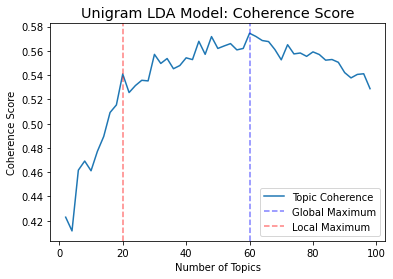

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data = df, x = 'num_topics', y = 'coherence', label = 'Topic Coherence')
plt.axvline(df["num_topics"][df['coherence'].idxmax()], linestyle = "--", color = "b", alpha = 0.5, label = "Global Maximum")
plt.axvline(df["num_topics"][df['coherence'][(df["num_topics"] > 0) & (df["num_topics"] < 30)].idxmax()], linestyle = "--", color = "r", alpha = 0.5, label = "Local Maximum")
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')
plt.title(label = "Unigram LDA Model: Coherence Score", fontsize = "x-large", fontweight = "roman")
plt.legend()

#ax.figure.savefig("/content/drive/MyDrive/bachelor_model_data/output.png", dpi = 1200)

In [ ]:
# printing number of topics for highest coherence score
df.iloc[df['coherence'].idxmax()]

# printing number of topics for highest coherence score between 0 and 30
df["num_topics"][df['coherence'][(df["num_topics"] > 0) & (df["num_topics"] < 30)].idxmax()]

Producing final instance of model for comparison

In [ ]:
# number of topics
num_topics = 20

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state = 100,
                                       passes=10,
                                       iterations = 10)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]

# Create Topics
topics = [' & '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
tak & siger & mennesker & dag & ret & medier & forstar & unge & fedt & politikere

------ Topic 1 ------
df & langt & gang & dkmedier & politik & ga & ar & klart & sælge & blevet

------ Topic 2 ------
gar & siger & inden & pct & gik & vide & kender & ytringsfrihed & dommeren & hele

------ Topic 3 ------
enig & ar & gar & kr & væk & politik & lang & kræver & egentlig & tale

------ Topic 4 ------
ar & dkgreen & snart & dkmedier & valg & søndag & gang & dk & arbejde & læs

------ Topic 5 ------
dkbiz & user & frem & sagt & sikre & gerne & unge & høre & dansk & eu

------ Topic 6 ------
ar & vel & danske & hele & tv & bestemt & dagen & første & finde & fejl

------ Topic 7 ------
del & betyder & dkmedier & tænker & enig & børn & danmark & bruge & første & fundet

------ Topic 8 ------
gang & dkmedier & tror & gar & dkgreen & grønne & dag & første & data & faktisk

------ Topic 9 ------
tv & dag & dkmedier & sldk & fc & kampe & direkte & dkbold & dksport & vises

--

### LDA: Combined Uni-gram and Bi-gram Model

Generating bigrams

In [ ]:
# building combined uni-gram and bi-gram model
processed_data = list(sent_to_words(tweets))

bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=10)

bigram_mod = gensim.models.phrases.Phraser(bigram)

#removing stopwords, creating bigrams
data_wo_stopwords = remove_stopwords(processed_data, stopword_list = lines_v2)

data_bigrams = create_bigrams(data_wo_stopwords)

gensim_dictionary = corpora.Dictionary(data_bigrams)

texts = data_bigrams

#building a corpus for the topic model
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

Optimising the model for coherence

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint

num_topics_ls = []
base_perplexity_ls = []
coherence_lda_model_base_ls = []

range_coherence = list(range(2,100,2))

# for-loop for making lda-models using 2 to 100 topics with 2 topic increments
for i in range_coherence:
  # number of topics
  num_topics = i
  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=num_topics, 
                                              random_state=100, 
                                              update_every=1, chunksize=100, passes=10, alpha='auto')
  
  # Compute Coherence Score
  coherence_model = CoherenceModel(model=lda_model, 
                                   texts=texts, 
                                 dictionary=gensim_dictionary,
                                 corpus = gensim_corpus, 
                                 coherence='c_v')
  coherence_lda_model_base = coherence_model.get_coherence()

  num_topics_ls.append(num_topics)
  base_perplexity_ls.append(base_perplexity)
  coherence_lda_model_base_ls.append(coherence_lda_model_base)

# merge results of for-loop in pandas dataframe
df = pd.DataFrame()
df["num_topics"] = num_topics_ls
df["perplexity"] = base_perplexity_ls
df["coherence"] = coherence_lda_model_base_ls

Visualising the coherence scores

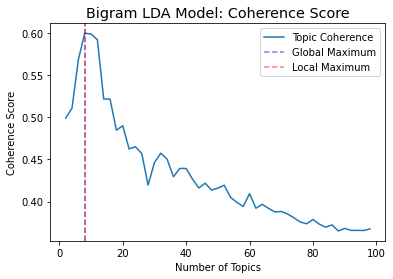

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data = df, x = 'num_topics', y = 'coherence', label = 'Topic Coherence')
plt.axvline(df["num_topics"][df['coherence'].idxmax()], linestyle = "--", color = "b", alpha = 0.5, label = "Global Maximum")
plt.axvline(df["num_topics"][df['coherence'][(df["num_topics"] > 0) & (df["num_topics"] < 30)].idxmax()], linestyle = "--", color = "r", alpha = 0.5, label = "Local Maximum")
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')
plt.title(label = "Bigram LDA Model: Coherence Score", fontsize = "x-large", fontweight = "roman")
plt.legend()
#ax.figure.savefig("/content/drive/MyDrive/bachelor_model_data/output.eps", format='eps')
ax.figure.savefig("/content/drive/MyDrive/bachelor_model_data/output_bigram.png", dpi = 1200)

In [ ]:
# printing number of topics for highest coherence score
df["num_topics"][df['coherence'].idxmax()]

Producing final instance of model for comparison

In [ ]:
# creating the final model with 8 topics
num_topics = 8

lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus, 
                                            id2word=gensim_dictionary, 
                                            num_topics=num_topics, 
                                            random_state=100, 
                                            update_every=1, 
                                            chunksize=100, 
                                            passes=10, 
                                            alpha='auto'
                                            )

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]

# Create Topics
topics = [' & '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
dkmedier & tror & tak & hold & tid & ret & vel & ga & præcis & twitter

------ Topic 1 ------
hele & tale & bedste & verden & made & bruge & ønsker & absolut & ude & dansk

------ Topic 2 ------
siger & danmark & enig & brug & vejen & hjælpe & gode & folk & penge & love

------ Topic 3 ------
dkgreen & debat & arsenal & gerne & langt & dk & selvfølgelig & lade & kampe & la

------ Topic 4 ------
dag & sldk & inden & nye & gang & star & ik & ligeglad & sociale & spille

------ Topic 5 ------
bedre & danske & giver & tv & sidste & sidder & me & gar & user & straffe

------ Topic 6 ------
ar & mener & læs & blevet & altsa & handler & stort & pldk & børn & virkelig

------ Topic 7 ------
df & dkbiz & the & you & folketinget & nyheder & taget & største & vist & sker

